In [11]:
from datasets import load_dataset, load_from_disk
import random
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from torchvision.utils import make_grid

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MacOS ARM-based CPU: mps
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

# Reproductibility
torch.manual_seed(53)
random.seed(53)
np.random.seed(53)
# Dataset parameters
batch_size = 32

## Create Dataset

In [26]:
dataset = load_dataset("zalando-datasets/fashion_mnist")

# Many Neural Network work better when the input values are centered around 0.
# .ToTensor is used to convert image values to [0, 1]
# lambda function maps [0, 1] to [-1, 1]
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_train)

### Visualize dataset

In [37]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=0)

x_train_var = np.var(train_dataset.train_data.numpy() / 255.0)


batch_image = next(iter(train_dataloader))[0]
batch_image.shape

/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([32, 1, 28, 28])

In [32]:
def normalize_im(images):
    shape = images.shape
    images = images.view(shape[0], -1)
    images -= images.min(1, keepdim=True)[0]
    images /= images.max(1, keepdim=True)[0]
    return images.view(shape)

def show_images(batch):
    plt.imshow(torch.permute(make_grid(normalize_im(batch)), (1,2,0)))
    plt.show()

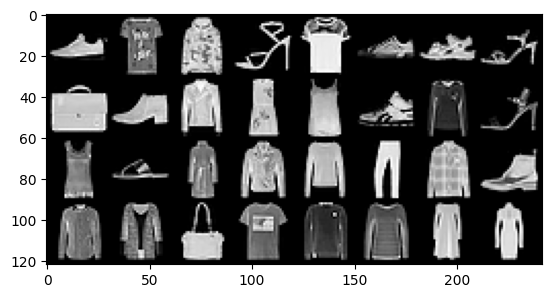

In [38]:
show_images(batch_image[:])

# VQVAE Implementation

In [9]:
!pip install -qq torch

In [ ]:
import torch.nn as nn
import torch

In [82]:
batch_size = 32
n_updates = 5000
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 64
beta = .25
learning_rate = 3e-4
log_interval = 50

In [83]:

class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(DEVICE)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices


In [84]:
import torch.nn.functional as F

class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x


In [85]:


class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta 
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)


In [86]:


class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi 
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)



In [87]:

class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(1, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity


In [88]:
import torch.optim as optim
model = VQVAE(n_hiddens, n_residual_hiddens,
              n_residual_layers, n_embeddings, embedding_dim, beta).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

model.train()
results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}

In [89]:
def train():
    for i in range(n_updates):
        (x, _) = next(iter(train_dataloader))
        x = x.to(DEVICE)
        optimizer.zero_grad()

        embedding_loss, x_hat, perplexity = model(x)
        recon_loss = torch.mean((x_hat - x)**2) / x_train_var
        loss = recon_loss + embedding_loss

        loss.backward()
        optimizer.step()

        results["recon_errors"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        if i % log_interval == 0:
            """
            save model and print values
            """

            print('Update #', i, 'Recon Error:',
                    np.mean(results["recon_errors"][-log_interval:]),
                    'Loss', np.mean(results["loss_vals"][-log_interval:]),
                    'Perplexity:', np.mean(results["perplexities"][-log_interval:]))



In [90]:
train()

Update # 0 Recon Error: 6.019863 Loss 6.023586 Perplexity: 1.3911422
Update # 50 Recon Error: 4.6418123 Loss 71.20081 Perplexity: 1.5621865
Update # 100 Recon Error: 2.198883 Loss 13.591423 Perplexity: 2.6398613
Update # 150 Recon Error: 1.4027762 Loss 35.191513 Perplexity: 2.5462239
Update # 200 Recon Error: 1.2297713 Loss 18.695107 Perplexity: 2.6858883
Update # 250 Recon Error: 1.2016094 Loss 14.924173 Perplexity: 2.5214884
Update # 300 Recon Error: 1.161502 Loss 16.028494 Perplexity: 2.3397267
Update # 350 Recon Error: 1.1008443 Loss 14.891644 Perplexity: 2.5212846
Update # 400 Recon Error: 1.0019011 Loss 11.845955 Perplexity: 2.958399
Update # 450 Recon Error: 0.90555865 Loss 9.033328 Perplexity: 3.4436874
Update # 500 Recon Error: 0.8666163 Loss 6.750146 Perplexity: 3.8721108
Update # 550 Recon Error: 0.82620573 Loss 5.7290673 Perplexity: 4.2831554
Update # 600 Recon Error: 0.79286027 Loss 5.070814 Perplexity: 4.798798
Update # 650 Recon Error: 0.800551 Loss 4.6260204 Perplexity:

In [91]:
from scipy.signal import savgol_filter
def plot_metrics(results):
    recon_errors = savgol_filter(results["recon_errors"], 19, 5)
    perplexities = savgol_filter(results["perplexities"], 19, 5)
    loss_vals = savgol_filter(results["loss_vals"], 19, 5)


    f = plt.figure(figsize=(16,4))
    ax = f.add_subplot(1,3,2)
    ax.plot(recon_errors)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,3)
    ax.plot(perplexities)
    ax.set_title('Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,1)
    ax.plot(loss_vals)
    ax.set_yscale('log')
    ax.set_title('Overall Loss')
    ax.set_xlabel('iteration')

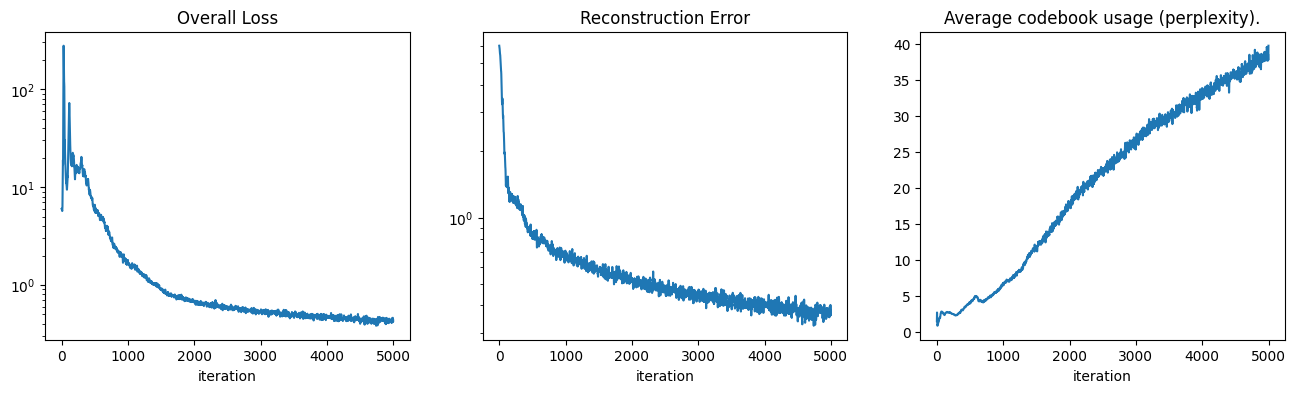

In [92]:
plot_metrics(results=results)

# Generate new images

## Sampling from latent space

In [93]:
def display_image_grid(x):
    x = make_grid(x.cpu().detach()+0.5)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [94]:
num_images = 30
latent_shape = (8, 8)

# Sample random indices from the latent space
sampled_indices = torch.randint(0, n_embeddings, 
                                    size=(num_images, *latent_shape), 
                                    device=DEVICE) 

# Convert indices to embeddings using the codebook
embedding_vectors = model.vector_quantization.embedding.weight[sampled_indices]

# Reshape to match decoder input dimensions (B, C, H, W)
embedding_vectors = embedding_vectors.permute(0, 3, 1, 2)  # Reorder dims (B, H, W, C) -> (B, C, H, W)
    
# Decode the sampled latent vectors into images
generated_images = model.decoder(embedding_vectors)

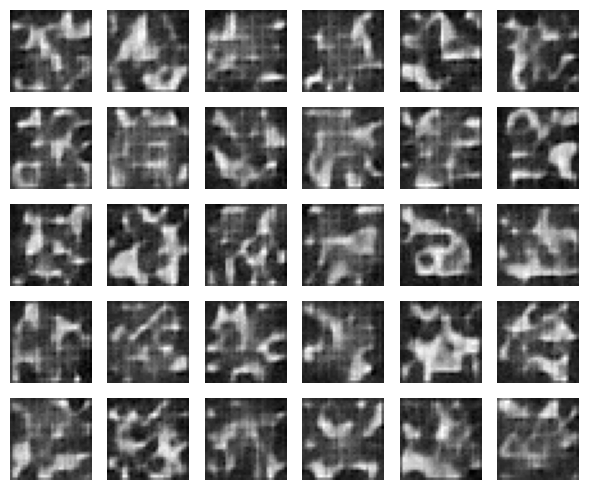

In [101]:
import matplotlib.pyplot as plt

# Parameters for the grid
grid_rows = 5  # Number of rows
grid_cols = 6  # Number of columns

# Create a figure with the specified grid size
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols, grid_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each image and plot it in the grid
for i, ax in enumerate(axes):
    if i < len(generated_images):
        ax.imshow(generated_images[i, 0].detach().cpu().numpy(), cmap='gray')  # Assumes single-channel images
        ax.axis('off')  # Turn off axes
    else:
        ax.axis('off')  # Turn off empty subplots

# Adjust spacing
plt.tight_layout()
plt.show()
